In [5]:
# import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import os

In [6]:
base_dataset_path = "D:/Projects/Deep Learning Project"
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
NUM_CLASSES = 7
EPOCHS = 100
SEED = 42

In [7]:
# Plot Training History from all CSVs in 'history' folder
histories = pd.read_csv('history/training_history_20250614_003851.csv')
histories.head()

,accuracy,loss,val_accuracy,val_loss,time
0,0.329618,1.892190,0.429089,1.490319,20250614_003851
1,0.435822,1.466961,0.480914,1.376706,20250614_003851
2,0.471350,1.385605,0.460017,1.383076,20250614_003851
3,0.492912,1.331002,0.491084,1.309385,20250614_003851
4,0.513532,1.286970,0.509334,1.302837,20250614_003851


### Plotting Model Training History (Accuracy & Loss Curves)

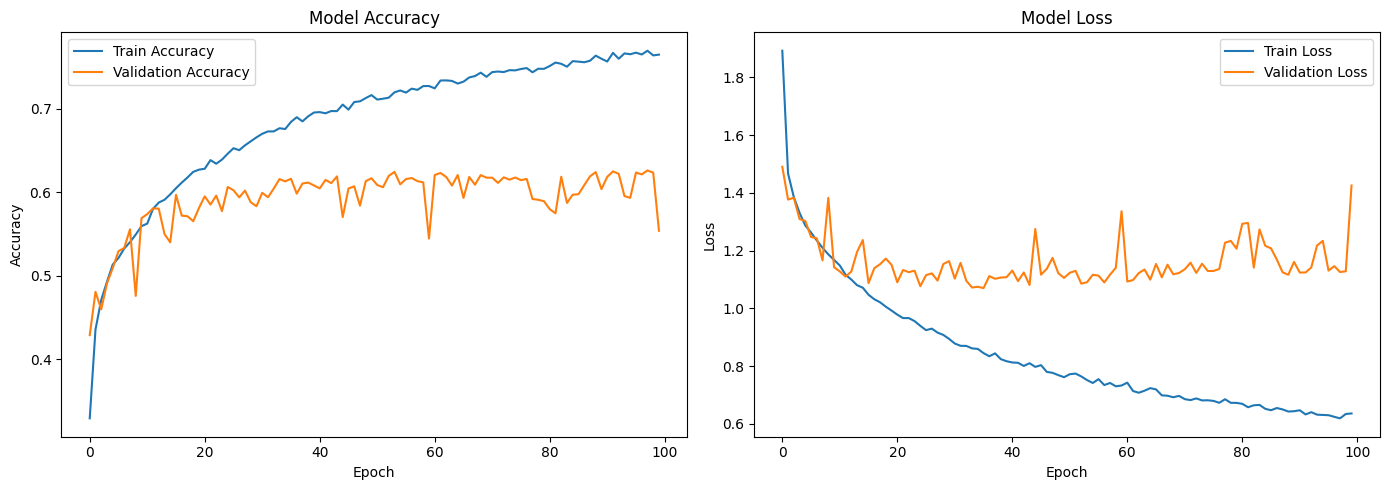

In [8]:
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(histories['accuracy'], label='Train Accuracy')
plt.plot(histories['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(histories['loss'], label='Train Loss')
plt.plot(histories['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
print(f"Loading test data from: {base_dataset_path}/test")
test_data = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dataset_path, 'test'),
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED,
    color_mode='grayscale'
)

Loading test data from: D:/Projects/Deep Learning Project/test
Found 7178 files belonging to 7 classes.


In [10]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

test_data = test_data.map(preprocess).cache().prefetch(1)


In [11]:
model = load_model("emotion_recognition_model.h5")
with open('emotion_labels.json', 'r') as f:
    label_map = json.load(f)
label_names = list(label_map.keys())

In [12]:
# Extract actual labels and predictions
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


### Confusion Matrix and Report

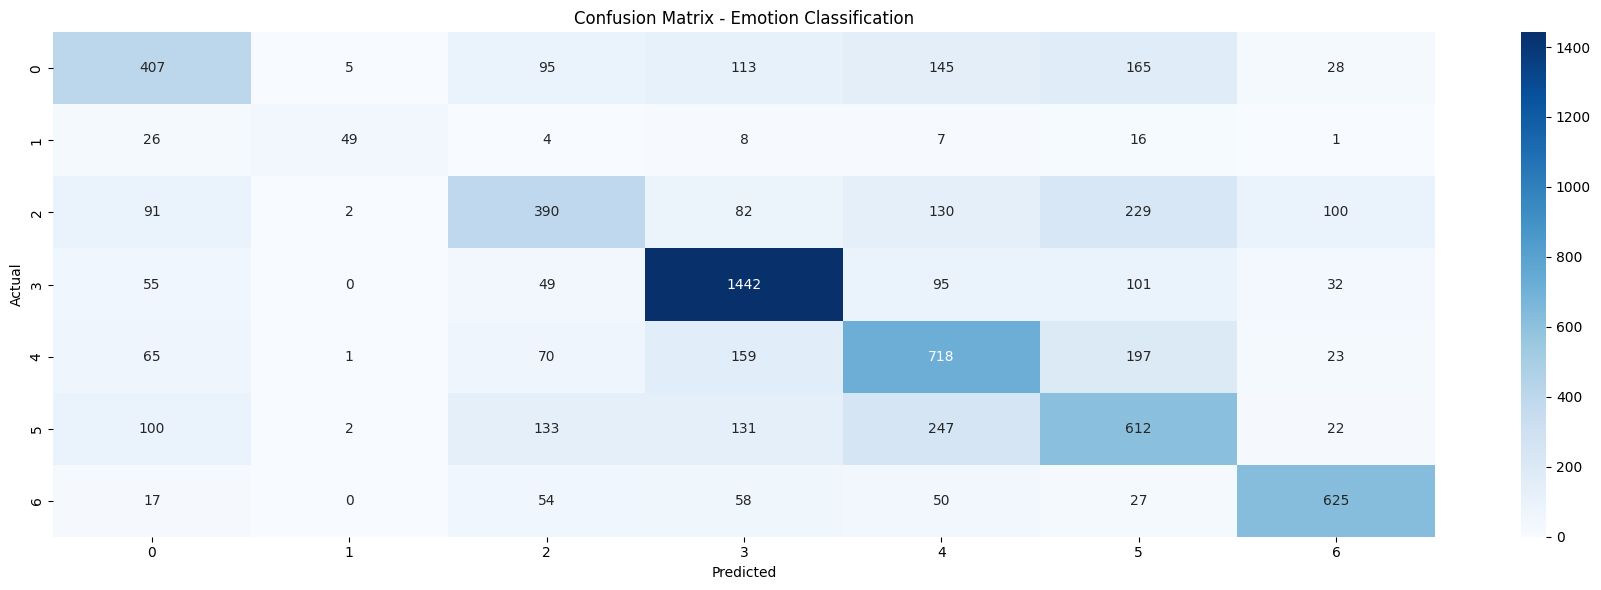

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(18,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Emotion Classification")
plt.tight_layout()
plt.show()

### Classification Report

Happy:
- 1484 correct predictions (row 4, column 4)
- Most predictions are accurate → strong detection of happy faces.

Neutral:
- 663 correct (last row, last column)
- Solid prediction performance, minimal confusion.

Sad is confused with:
- happy (103 times)
- surprise (141 times)
- angry (91 times)

Fear is confused with:
- angry (121 times)
- surprise (161 times)
- sad (134 times)


Disgust:
- Only 59 correct
- Confused with angry, fear, and even surprise

- Overall Accuracy	0.64 → Better than random (which would be ~14%)
- Happy	Precision: 0.83, Recall: 0.84, F1: 0.83 very strong
- Neutral	F1-score: 0.78 solid
- Disgust	Precision: 0.86 but recall is only 0.53 → overpredicting in a few confident spots

In [14]:
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

           0       0.53      0.42      0.47       958
           1       0.83      0.44      0.58       111
           2       0.49      0.38      0.43      1024
           3       0.72      0.81      0.77      1774
           4       0.52      0.58      0.55      1233
           5       0.45      0.49      0.47      1247
           6       0.75      0.75      0.75       831

    accuracy                           0.59      7178
   macro avg       0.61      0.56      0.57      7178
weighted avg       0.59      0.59      0.59      7178



In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# --- Configuration for Image Size ---
IMG_HEIGHT = 48
IMG_WIDTH = 48
NUM_CHANNELS = 1 # Your model expects grayscale (1 channel)

# Load model and labels
model = load_model("emotion_recognition_model.h5")
label_map = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral",
}

# Set up webcam and face detection
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

print("📸 Press 's' to capture + plot, 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    # faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for x, y, w, h in faces:
        face_gray = gray[y:y + h, x:x + w] # Use the already grayscale 'gray' frame

        # Resize the grayscale face to 48x48
        face_resized_gray = cv2.resize(face_gray, (IMG_HEIGHT, IMG_WIDTH))

        # Normalize pixel values to 0-1 range
        face_normalized = face_resized_gray.astype("float32") / 255.0

        # Expand dimensions to (1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
        # For grayscale, NUM_CHANNELS is 1
        face_input = np.expand_dims(face_normalized, axis=(0, -1)) # Adds batch and channel dim


        # face_rgb = frame[y:y + h, x:x + w]
        # face_rgb = cv2.cvtColor(face_rgb, cv2.COLOR_BGR2RGB)
        # face_resized = cv2.resize(face_rgb, (48, 48))
        # face_normalized = face_resized.astype("float32") / 255.0
        # face_input = np.expand_dims(face_normalized, axis=0)

        prediction = model.predict(face_input, verbose=0)
        label_index = np.argmax(prediction[0])
        label = label_map[label_index]

        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(
            frame, label, (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2
        )

    # Show frame and check for key
    cv2.imshow("Emotion Detector — Press S to plot, Q to quit", frame)
    key = cv2.waitKey(1) & 0xFF

    if key == ord("s") and len(faces) > 0:
        print(f"🧠 Predicted: {label}")
        print("🔢 Probabilities:")
        for i, prob in enumerate(prediction[0]):
            print(f"{label_map[i]}: {prob:.3f}")

        plt.figure(figsize=(10, 4))

        # Show the face
        plt.subplot(1, 2, 1)
        plt.imshow(face_resized, cmap="gray")
        plt.title(f"Captured Face\nPredicted: {label}")
        plt.axis("off")

        # Show bar chart
        plt.subplot(1, 2, 2)
        bars = plt.barh(list(label_map.values()), prediction[0], color="skyblue")
        bars[label_index].set_color("orange")
        plt.xlabel("Probability")
        plt.title("Emotion Prediction")
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

    elif key == ord("q"):
        print("👋 Exiting cleanly...")
        break

# Final cleanup
cap.release()
cv2.destroyAllWindows()
import time

time.sleep(0.5)
cv2.waitKey(1)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'expw_emotion_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Real-time Webcam Emotion Detection